In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster_lagged.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos

In [2]:
static_data = pd.read_pickle(STATIC_DATASET_PATH)
print(static_data.shape)
static_data.head()

(76277, 132)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I should modify the fill_profits function from the preprocessing module. As I will be only adding a column, that shouldn't affect the old code (I could add a boolean in the signature if anything goes wrong). Let's use the old functions to get the data needed.

We have to differentiate the case when the customer has viewed an offer in the last 10 days, from the case in which it hasn't.

In [3]:
static_data.viewed.mean()

0.7502523696527131

So, 75% of the sent offers are seen.

In [4]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

Basic preprocessing
CPU times: user 3.25 s, sys: 204 ms, total: 3.45 s
Wall time: 2.21 s


In [5]:
print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,0.0,0.0,1.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,0.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [6]:
data.person.nunique()

17000

In [7]:
data.time.nunique()

120

In [8]:
received, viewed, completed, transactions = pp.split_transcript(data)

In [9]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

print(ts.shape)
ts.head()

(120, 17000)


,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43,e2127556f4f64592b11af22de27a7932,8ec6ce2a7e7949b1bf142def7d0e0586,68617ca6246f4fbc85e91a2a49552598,389bc3fa690240e798340f5a15918d5c,c4863c7985cf408faee930f111475da3,2eeac8d8feae4a8cad5a6af0499a211d,aa4862eba776480b8bb9c68455b8c2e1,31dda685af34476cad5bc968bdb01c53,...,22617705eec442e0b7b43e5c5f56fb17,fc966e9c3edc4578a1fb4c6a8c2659c2,47683732768a4f7db7abb710ca22e66e,3873fe915496482eb589fa316ae7b0db,8578196a074a4f328976e334fa9383a3,9fcbff4f8d7241faa4ab8a9d19c8a812,ebae5093b436466c9fbd097cb7434023,912b9f623b9e4b4eb99b6dc919f09a93,3045af4e98794a04a5542d3eac939b1f,da7a7c0dcfcb41a8acc7864a53cf60fb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ts.sum().head()

78afa995795e4d85b5d9ceeca43f5fef    159.27
a03223e636434f42ac4c3df47e8bac43      4.65
e2127556f4f64592b11af22de27a7932     57.73
8ec6ce2a7e7949b1bf142def7d0e0586      0.00
68617ca6246f4fbc85e91a2a49552598      0.24
dtype: float64

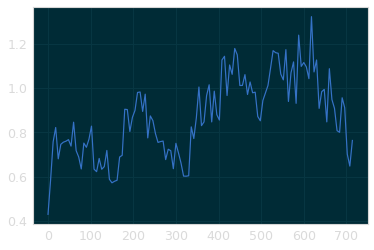

In [12]:
ts.mean(axis=1).plot()

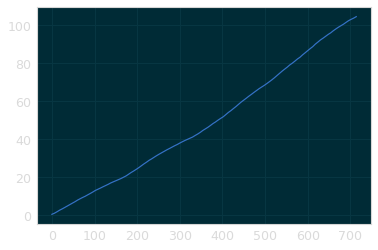

In [13]:
ts.cumsum().mean(axis=1).plot()

In [14]:
sending_times = received.time.unique()
sending_times

array([  0, 168, 336, 408, 504, 576])

In [15]:
sending_times[1:] - sending_times[:-1]

array([168, 168,  72,  96,  72])

In [16]:
168/24

7.0

Let's assume that the period of interest for an offer is always 10 days after it was received. Let's make a table that shows if an offer was received in the past 10 days.

In [17]:
received.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,0.0,0.0,1.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,0.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [18]:
user = received[received.person == received.person[0]]
user

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,2017-05-09,F,100000.0,0,17295,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,2017-05-09,F,100000.0,0,17295,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0


In [19]:
offers = portfolio.id.values

In [20]:
offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                        index=data.time.unique(), columns=offers)
offer_ts.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
delta = 24 * 10
for i, row in user.iterrows():
    offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1

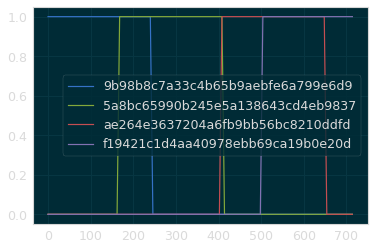

In [22]:
offer_ts.loc[:, user.offer_id].plot()

In [23]:
def get_offers_ts(user_received, portfolio, data, delta = 24 * 10, viewed=False):
    """ 
    Given the received sequence for a user, this function returns a time series
    dataframe containing a 1 in a 10 days period after receiving an offer.
    It can filter out the non-viewed offers.
    Args:
        user_received(dataframe): The received offers for one user.
        portfolio(dataframe): The original portfolio of offers (just to get the offer ids).
        data(dataframe): The original transcript (just to get the time values).
        delta(int): The period of relevance for an offer.
        viewed(boolean): Whether to show only the offers that were viewed.
    """
    offers = portfolio.id.values
    offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                            index=data.time.unique(), columns=offers)
    for i, row in user_received.iterrows():
        if viewed:
            if row.viewed:
                offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
        else:
            offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
    # Fill the "no-offer" column
    offer_ts['no_offer'] = (offer_ts.sum(axis=1) == 0).astype(int)
    return offer_ts

Let's plot the offers' relevant periods considering all the offers received and only those that were viewed.

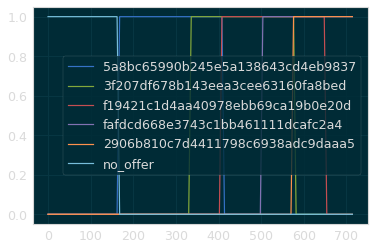

In [24]:
user = static_data[static_data.person == static_data.person[1]]
interesting_offers = user.offer_id.tolist() + ['no_offer']
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.loc[:, interesting_offers].plot()

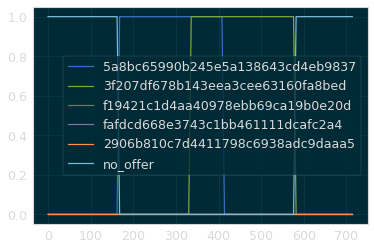

In [25]:
get_offers_ts(user, portfolio, data, viewed=True).loc[:, interesting_offers].plot()

There is overlap. Let's see if the offers, in mean, behave similarly in their full period of interest. If that is true, a model could be implemented on a day-to-day basis, and the overlapping zones could be ignored, or taken into account in an easier way.

In [26]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
offer = portfolio.id[0]
offer

'ae264e3637204a6fb9bb56bc8210ddfd'

In [28]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

In [29]:
ts.shape

(120, 17000)

In [30]:
static_data.shape

(76277, 132)

In [31]:
%time multi_offer_times = static_data.groupby('person').apply(lambda x: get_offers_ts(x, portfolio, data, viewed=False).stack() )

CPU times: user 1min 59s, sys: 516 ms, total: 2min
Wall time: 2min


In [32]:
multi_offer_times.shape

(16994, 1320)

In [33]:
portfolio.shape

(10, 9)

In [34]:
120 * 11

1320

In [35]:
multi_offer_times.head()

0    \
                                 ae264e3637204a6fb9bb56bc8210ddfd   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 4d5c57ea9a6940dd891ad53e9dbe8da0   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 3f207df678b143eea3cee63160fa8bed   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 2298d6c36e964ae4a3e7e9706d1fb8c2   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 fafdcd668e3743c1bb461111dcafc2a4   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              1.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 5a8bc65990b245e5a138643cd4eb9837   
person                                               

In [36]:
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.stack()

0    ae264e3637204a6fb9bb56bc8210ddfd    0.0
     4d5c57ea9a6940dd891ad53e9dbe8da0    0.0
     3f207df678b143eea3cee63160fa8bed    0.0
     9b98b8c7a33c4b65b9aebfe6a799e6d9    0.0
     0b1e1539f2cc45b7b9fa7c272da2e1d7    0.0
     2298d6c36e964ae4a3e7e9706d1fb8c2    0.0
     fafdcd668e3743c1bb461111dcafc2a4    0.0
     5a8bc65990b245e5a138643cd4eb9837    0.0
     f19421c1d4aa40978ebb69ca19b0e20d    0.0
     2906b810c7d4411798c6938adc9daaa5    0.0
     no_offer                            1.0
6    ae264e3637204a6fb9bb56bc8210ddfd    0.0
     4d5c57ea9a6940dd891ad53e9dbe8da0    0.0
     3f207df678b143eea3cee63160fa8bed    0.0
     9b98b8c7a33c4b65b9aebfe6a799e6d9    0.0
     0b1e1539f2cc45b7b9fa7c272da2e1d7    0.0
     2298d6c36e964ae4a3e7e9706d1fb8c2    0.0
     fafdcd668e3743c1bb461111dcafc2a4    0.0
     5a8bc65990b245e5a138643cd4eb9837    0.0
     f19421c1d4aa40978ebb69ca19b0e20d    0.0
     2906b810c7d4411798c6938adc9daaa5    0.0
     no_offer                            1.0
12   ae264

## 1) Let's get the spent money in 10 days from the offer reception, without taking into account the overlapping or the views.

In [37]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

CPU times: user 3.45 s, sys: 16 ms, total: 3.47 s
Wall time: 2.31 s


In [38]:
static_data.shape

(76277, 132)

In [39]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
from tqdm import tqdm

In [41]:
# TODO: Make a function out of the code below...

In [42]:
def get_spent_days_static(static_data, preprocessed_data, days=10*24):
    """
    Get a static data version of the profit N days dataset.
    Calculates the total money spent for each customer, in the 10 days after
    an offer is shown.
    Args:
        static_data(dataframe): The 'offer success' version of the static data.
        preprocessed_data(dataframe): the result of 'basic_preprocessing'.
        days(int): The number of days to calculate the profits.
    """
    received, viewed, completed, transactions = pp.split_transcript(preprocessed_data)
    
    results = list()
    for idx, row in tqdm(list(static_data.iterrows())):
        record = dict()
    
        # Id of the record
        record['person'] = row.person
        record['time'] = row.time
        record['offer_id'] = row.offer_id
    
        record['spent_10_days'] = transactions[(transactions.person == row.person) &
                                               (transactions.time > row.time) &
                                               (transactions.time <= row.time + days)
                                              ].amount.sum()
        results.append(record)
    
    return static_data.merge(pd.DataFrame(results), 
                             on=['person', 'time', 'offer_id'], how='left')

In [45]:
filled = get_spent_days_static(static_data, data)

100%|██████████| 76277/76277 [25:24<00:00, 50.02it/s]


In [46]:
print(filled.shape)
filled.head()

(76277, 133)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.87
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.93


In [47]:
filled.spent_10_days.sum()

2759280.54

In [48]:
filled.to_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [49]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

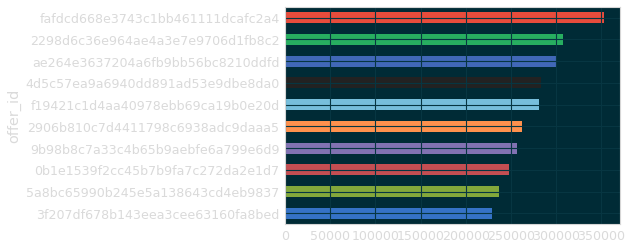

In [50]:
filled.groupby('offer_id').spent_10_days.sum().sort_values().plot(kind='barh')

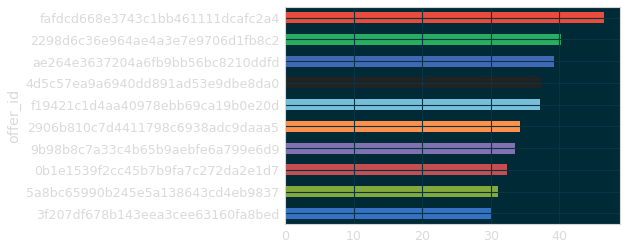

In [51]:
filled.groupby('offer_id').spent_10_days.mean().sort_values().plot(kind='barh')

In [52]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


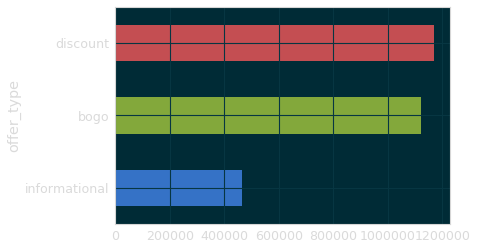

In [53]:
filled.groupby('offer_type').spent_10_days.sum().sort_values().plot(kind='barh')

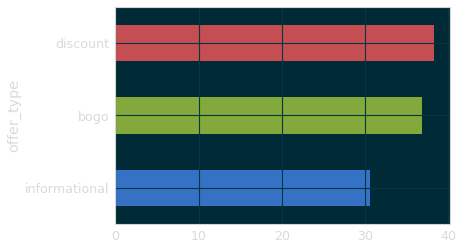

In [54]:
filled.groupby('offer_type').spent_10_days.mean().sort_values().plot(kind='barh')

## 2) Let's consider the non-viewed for the "null" offer.

In [55]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

CPU times: user 2.73 s, sys: 48 ms, total: 2.78 s
Wall time: 1.74 s


In [56]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [57]:
filled['offer_choice'] = filled['offer_id']
filled.loc[filled['viewed'] == 0, 'offer_choice'] = 'no_offer'

In [58]:
filled.offer_choice.value_counts()

no_offer                            19050
fafdcd668e3743c1bb461111dcafc2a4     6932
4d5c57ea9a6940dd891ad53e9dbe8da0     6861
2298d6c36e964ae4a3e7e9706d1fb8c2     6853
f19421c1d4aa40978ebb69ca19b0e20d     6698
ae264e3637204a6fb9bb56bc8210ddfd     6318
5a8bc65990b245e5a138643cd4eb9837     6208
0b1e1539f2cc45b7b9fa7c272da2e1d7     4500
2906b810c7d4411798c6938adc9daaa5     4363
3f207df678b143eea3cee63160fa8bed     4263
9b98b8c7a33c4b65b9aebfe6a799e6d9     4231
Name: offer_choice, dtype: int64

In [59]:
filled.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.87,no_offer
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.93,no_offer


In [60]:
print(filled.shape)
print(filled.columns)

(76277, 134)
Index(['person', 'time', 'offer_id', 'age', 'became_member_on', 'gender',
       'income', 'missing_demographics', 'member_epoch_days', 'difficulty',
       ...
       'reward_0.0_success_ratio', 'reward_5.0_success_ratio',
       'reward_3.0_success_ratio', 'reward_2.0_success_ratio',
       'channel_web_success_ratio', 'channel_email_success_ratio',
       'channel_social_success_ratio', 'channel_mobile_success_ratio',
       'spent_10_days', 'offer_choice'],
      dtype='object', length=134)


In [61]:
data = filled
time_limit = 450
drop_time = True
anon_person = True
anon_offer = True
data = data.drop('became_member_on', axis=1)
if anon_person:
        data = data.drop('person', axis=1)
if anon_offer:
        data = data.drop('offer_id', axis=1)
X = data.drop(pp.FUTURE_INFO, axis=1)
y = data['success']
X_train, X_test, y_train, y_test = sd.time_split(X, y, time_limit,
                                              drop_time=drop_time)

In [62]:
X_train.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,f19421c1d4aa40978ebb69ca19b0e20d
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.49,3f207df678b143eea3cee63160fa8bed


In [63]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [64]:
data['profit_10_days'] = data.spent_10_days - data.actual_reward

In [65]:
data.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice,profit_10_days
0,168,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837,22.16
1,336,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed,46.51
2,408,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer,41.51
3,504,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.87,no_offer,94.87
4,576,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.93,no_offer,56.93


In [66]:
from sklearn.preprocessing import LabelEncoder

In [67]:
class BasicEncoderProfits(pp.BasicEncoder):
    """ 
    Transforms the Basic dataset. Adds the encoding for the offer choice or
    other custom features (may be offer_id for example). """

    def __init__(self, custom_features=list()):
        super().__init__()
        self.custom_encoders = {feat: LabelEncoder() for feat in custom_features}

    def fit(self, X, y=None):
        """ Get the encodings for the offer choice. """
        super().fit(X, y)
        for feat, encoder in self.custom_encoders.items():
            encoder.fit(X[feat])
        return self

    def transform(self, X):
        """ Encode offer types and gender, and all the custom features. """
        res = super().transform(X)
        for feat, encoder in self.custom_encoders.items():
            res[feat] = encoder.transform(X[feat])
        return res

    def inverse_transform(self, X):
        """ Transform back to the original encoding. """
        res = super().inverse_transform(X)
        for feat, encoder in self.custom_encoders.items():
            res[feat] = encoder.inverse_transform(X[feat])
        return res

In [68]:
def fill_null_offer(data):
    """ Fill the 'null' offer data when an offer was not viewed"""
    
    data.loc[data['viewed'] == 0, 'offer_id'] = 'no_offer'
    z_cols = ['difficulty',
               'duration',
               'reward_t',
               'channel_web',
               'channel_mobile',
               'channel_email',
               'channel_social',
               'expected_finish']
    data.loc[data.offer_id=='no_offer', data.columns.isin(z_cols)] = 0
    data.loc[data.offer_id=='no_offer', 'offer_type'] = 'no_offer'

    return data

In [69]:
def get_profit_10_days_data(basic_dataset_path=os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'),
                            train_times=[0, 168],
                            test_times=[408],
                            drop_time=True,
                            anon_person=True,
                            drop_offer_id=True,
                            fill_null=True,
                            target='profit_10_days'):
    """
    Generates the dataset to predict the profits in 10 days for each offer.
    The profits are calculated as the money spent minus the paid reward (if any).
    Args:
        basic_dataset_path(str): The path to the pickle containing the basic
            dataset
        time_limit(int): The limit to split the train and test sets.
        drop_time(boolean): Whether to drop the absolute time dependent
            features.
        anon_person(boolean): Whether to drop unique identifiers to customers.
        anon_offer(boolean): Whether to drop unique identifiers to offers.

    Returns:
        X_train(pd.DataFrame): The training dataset.
        X_test(pd.DataFrame): The test dataset.
        y_train(pd.Series): The training target.
        y_test(pd.Series): The test target.
        BasicEncoderProfits: An encoder to use in an ML pipeline.
    """
    data = pd.read_pickle(basic_dataset_path)
    
    custom_features = ['offer_id']
    if fill_null:
        data = fill_null_offer(data)
    if anon_person:
        data = data.drop('person', axis=1)
    if drop_offer_id:
        data = data.drop('offer_id', axis=1)
        custom_features.remove('offer_id')
    data['profit_10_days'] = data.spent_10_days - data.actual_reward
    data = data.drop(['became_member_on', 'spent_10_days'], axis=1)
    
    X = data.drop(pp.FUTURE_INFO + ['profit_10_days'], axis=1)
    y = data[target]
    
    # Split the train-test data
    X_train = X[X.time.isin(train_times)]
    X_test = X[X.time.isin(test_times)]
    y_train = y[X.time.isin(train_times)]
    y_test = y[X.time.isin(test_times)]
    if drop_time:
        X_train = X_train.drop('time', axis=1)
        X_test = X_test.drop('time', axis=1)
    
    encoder = encoder = BasicEncoderProfits(custom_features=custom_features)
    
    return X_train, X_test, y_train, y_test, encoder

In [70]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)

In [71]:
X_train.offer_type.unique()

array(['informational', 'bogo', 'discount', 'no_offer'], dtype=object)

In [72]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(target='viewed')
y_train.name

'viewed'

In [73]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(fill_null=False, target='viewed')
X_train.offer_type.unique()

array(['informational', 'bogo', 'discount'], dtype=object)

In [74]:
encoder.custom_encoders

{}

In [75]:
encoder.fit(X_train)

BasicEncoderProfits(custom_features=None)

In [76]:
X_train_t = encoder.transform(X_train)
X_train_t.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,33.0,1.0,72000.0,0,17277,0.0,3.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,NaN,NaN,1,17646,5.0,5.0,0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,40.0,2.0,57000.0,0,17540,0.0,4.0,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,40.0,2.0,57000.0,0,17540,7.0,7.0,1,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,59.0,0.0,90000.0,0,16864,10.0,10.0,1,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
X_train_o = encoder.inverse_transform(X_train_t)

In [78]:
X_train_o.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,59.0,F,90000.0,0,16864,10.0,10.0,discount,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Let's train a simple profits estimator

In [79]:
from xgboost import XGBRegressor

In [80]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)

In [81]:
model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBRegressor(max_depth=4, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

In [82]:
%time model.fit(X_train, y_train)

CPU times: user 16.1 s, sys: 27.8 ms, total: 16.2 s
Wall time: 15.7 s


Pipeline(memory=None,
     steps=[('encoder', BasicEncoderProfits(custom_features=None)), ('imputer', BasicImputer(fill_mode=[])), ('estimator', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, m...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [83]:
y_train_pred = model.predict(X_train)

In [84]:
from sklearn.metrics import mean_squared_error as mse

In [85]:
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train, y_train_pred))))

Training error (RMSE) = 49.68743573619416


In [86]:
y_test_pred = model.predict(X_test)
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test, y_test_pred))))

Test error (RMSE) = 65.56712234730111


In [87]:
X_test.shape

(12778, 119)

In [88]:
test_res = pd.DataFrame(columns=['true', 'pred'])
test_res['true'] = y_test
test_res['pred'] = y_test_pred
test_res

,true,pred
2,41.51,161.283142
10,40.08,23.791924
15,41.10,64.386620
19,69.19,56.681511
24,22.45,223.449234
29,6.59,58.785099
36,133.12,61.480885
41,10.65,12.679276
45,81.39,55.418987
50,0.00,-3.409606


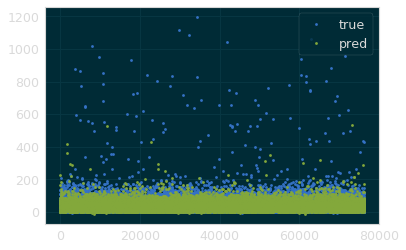

In [89]:
test_res.sort_values(by='true').plot(style='.')

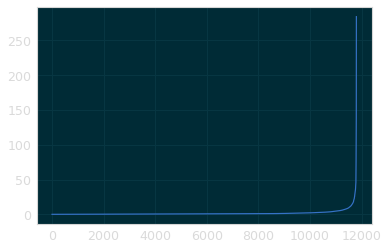

In [90]:
((test_res.pred - test_res.true) / test_res.true).abs().sort_values().reset_index(drop=True).plot()

In [91]:
relative_error = ((test_res.pred - test_res.true) / test_res.true).abs()

In [92]:
(relative_error == np.inf).sum()

977

In [93]:
relative_error[np.isfinite(relative_error)].mean()

1.6332644627362536

### Let's pick a user and decide which would be the most profitable offer we can send them.

In [94]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

Basic preprocessing
CPU times: user 1.77 s, sys: 28 ms, total: 1.8 s
Wall time: 1.8 s


In [95]:
def predict_profit_with_offer(model, data, offer, drop_offer_id=False):
    """ Predicts how much will be the profit in 10 days for a given an offer. """
    samples = data.copy()
    if drop_offer_id:
        std_offer = offer.drop('id').rename(index={'reward': 'reward_t'})
    else:
        std_offer = offer.rename(index={'reward': 'reward_t', 'id': 'offer_id'})
    samples.loc[:, std_offer.index] = np.repeat(std_offer.values.reshape(1, -1), samples.shape[0], axis=0)
    
    return pd.Series(model.predict(samples), name=offer.id).T

In [96]:
predict_profit_with_offer(model, X_test, portfolio.iloc[1]).head()

0    166.283401
1     26.076126
2     64.386620
3     60.839657
4    194.869888
Name: 4d5c57ea9a6940dd891ad53e9dbe8da0, dtype: float32

In [97]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [98]:
complete_portfolio = portfolio.copy()
null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                       index=complete_portfolio.columns, name=complete_portfolio.shape[0])
complete_portfolio = complete_portfolio.append(null_offer)
complete_portfolio

,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [99]:
res = complete_portfolio.apply(lambda x: predict_profit_with_offer(model, X_test, x), axis=1).T
res.columns = complete_portfolio.id
res.shape

(12778, 11)

In [100]:
res.head()

id,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,no_offer
0,172.773361,166.283401,164.727707,168.690842,157.889359,172.720535,185.436066,164.004715,168.394806,170.829453,161.283142
1,26.946207,26.076126,28.519405,27.075087,23.791924,28.589231,31.710272,27.332481,26.838003,29.067387,26.223358
2,84.755737,64.386620,59.507278,84.568245,76.274399,88.683197,96.699623,54.470222,64.624115,93.288048,60.267361
3,65.903229,60.839657,60.668015,64.852112,64.427925,67.332115,80.868492,56.681511,63.297794,68.562347,59.588730
4,212.203644,194.869888,200.652451,211.634659,201.878250,216.646103,223.449234,194.774796,196.580368,222.571884,200.903305


In [101]:
res.describe()

id,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,no_offer
count,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000,12778.000000
mean,38.646446,35.012550,35.701847,39.120037,37.150085,41.013008,47.945843,33.199703,35.952854,42.544369,33.969223
std,32.790443,30.118114,27.073235,32.483715,35.595108,31.685730,35.326900,26.666719,30.290836,32.057640,29.407246
min,-12.227659,-11.472479,-8.584282,-9.678270,-25.050116,-12.092134,-3.013086,-11.351426,-6.650651,-10.295974,-7.863291
25%,12.071297,11.032092,14.493437,12.531816,10.380508,14.065307,18.798587,12.065371,12.133776,15.454016,12.094405
50%,33.105923,29.871875,33.169220,34.069429,30.808695,36.035975,42.507177,30.135440,31.404767,38.069677,30.854597
75%,59.189095,52.636271,50.952511,59.237474,55.493708,62.343003,71.431698,48.089652,53.133011,63.692473,49.141231
max,541.126770,432.425537,481.332581,524.403687,429.158447,439.593628,391.865234,410.179352,404.472717,464.510681,495.320282


In [102]:
selected_offers = res.idxmax(axis=1)
selected_offers.value_counts().reset_index().merge(portfolio, left_on='index', right_on='id')

,index,0,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
0,fafdcd668e3743c1bb461111dcafc2a4,8860,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
1,2906b810c7d4411798c6938adc9daaa5,1932,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,736,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
3,2298d6c36e964ae4a3e7e9706d1fb8c2,298,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,278,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
5,f19421c1d4aa40978ebb69ca19b0e20d,151,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
6,ae264e3637204a6fb9bb56bc8210ddfd,82,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
7,3f207df678b143eea3cee63160fa8bed,62,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
8,4d5c57ea9a6940dd891ad53e9dbe8da0,58,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
9,5a8bc65990b245e5a138643cd4eb9837,33,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0


In [103]:
def choose_offer(model, X, portfolio, add_null_offer=True):
    """
    Given a model and a features dataframe it returns the
    model that maximizes the model predictions.
    """
    complete_portfolio = portfolio.copy()
    
    # Add the null offer
    if add_null_offer:
        null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=complete_portfolio.columns, 
                               name=complete_portfolio.shape[0])
        complete_portfolio = complete_portfolio.append(null_offer)
    
    res = complete_portfolio.apply(
        lambda x: predict_profit_with_offer(model, X, x), axis=1).T
    res.columns = complete_portfolio.id
    
    return res.idxmax(axis=1)

In [104]:
selected_offers = choose_offer(model, X_test, portfolio)
selected_offers.head()

0    fafdcd668e3743c1bb461111dcafc2a4
1    fafdcd668e3743c1bb461111dcafc2a4
2    fafdcd668e3743c1bb461111dcafc2a4
3    fafdcd668e3743c1bb461111dcafc2a4
4    fafdcd668e3743c1bb461111dcafc2a4
dtype: object

In [105]:
(X_test.offer_id == selected_offers.values).mean()

0.08162466739708875

In [106]:
(X_test.offer_id == selected_offers.values).sum()

1043

We could check the actual profit on those samples that, by chance, were sent the selected offer.

In [107]:
coincidences = y_test[X_test.offer_id == selected_offers.values]
coincidences.sum()

51836.95

Now we select a random sample, of the same size, from the test set, and compare with the above profit.

In [108]:
np.random.seed(2018)
np.random.choice(y_test, coincidences.shape[0], replace=False).sum()

44223.119999999995

## 3) Let's find P(viewed | offer)

In [110]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(fill_null=False, 
                        target='viewed', drop_offer_id=False)
y_train.name

'viewed'

In [111]:
model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

In [112]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

%time model.fit(X_train, y_train)

# Predict and show results
y_train_pred = model.predict(X_train)
print('-' * 44 + 'TRAIN RESULTS' + '-' * 44)
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('Classification Report:')
print(classification_report(y_train, y_train_pred))
print('-' * 100)

y_test_pred = model.predict(X_test)
print('-' * 44 + 'TEST RESULTS' + '-' * 44)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('-' * 100)

print('\n' + '_' * 51)
print('| MAIN METRIC (test f1-score): {} |'.format(
    f1_score(y_test, y_test_pred)))
print('-' * 51)

CPU times: user 26.5 s, sys: 7.81 ms, total: 26.5 s
Wall time: 26.5 s
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[ 3312  2882]
 [  663 18462]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65      6194
           1       0.86      0.97      0.91     19125

   micro avg       0.86      0.86      0.86     25319
   macro avg       0.85      0.75      0.78     25319
weighted avg       0.86      0.86      0.85     25319

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[1091 2027]
 [1127 8533]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.35      0.41      3118
           1       0.81      0.88      0.84      9

In [113]:
import src.visualization.visualize as vis

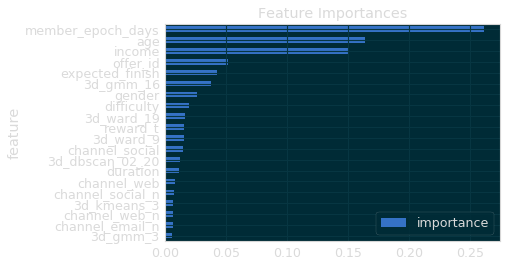

<Figure size 432x288 with 0 Axes>

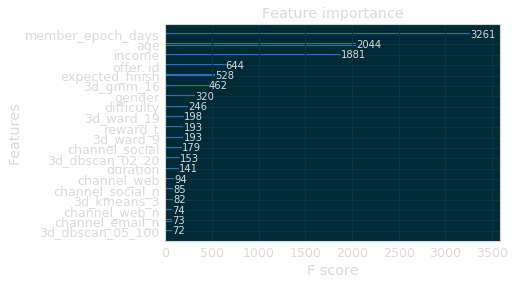

In [114]:
vis.show_feat_importances(model, X_train)

In [115]:
vis_probas_train = model.predict_proba(X_train)[:, 1]
vis_probas_test = model.predict_proba(X_test)[:, 1]

### Now, the full model

In [116]:
vis_probas_train

array([0.9100658 , 0.9767224 , 0.8507627 , ..., 0.94540256, 0.9370554 ,
       0.6583747 ], dtype=float32)

(array([  110.,   498.,   974.,  1185.,  1403.,  2087.,  2528.,  2501.,
         3922., 10111.]),
 array([0.02325942, 0.12075736, 0.2182553 , 0.31575322, 0.41325116,
        0.5107491 , 0.60824704, 0.705745  , 0.8032429 , 0.90074086,
        0.9982388 ], dtype=float32),
 <a list of 10 Patch objects>)

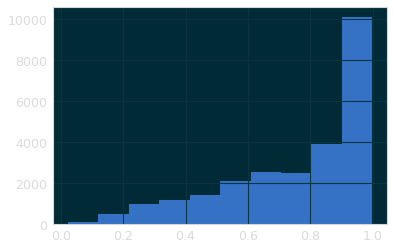

In [117]:
plt.hist(vis_probas_train)

In [118]:
vis_probas_train.shape

(25319,)

In [119]:
y_train.shape

(25319,)

In [120]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse

X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)
print(y_train.name)

profit_est_model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBRegressor(max_depth=4, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

%time profit_est_model.fit(X_train, y_train)

profit_train_pred = profit_est_model.predict(X_train)
profit_test_pred = profit_est_model.predict(X_test)

profit_10_days
CPU times: user 14.7 s, sys: 27.8 ms, total: 14.7 s
Wall time: 14.7 s


In [121]:
X_train.offer_id.unique()

array(['5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4', 'no_offer',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [122]:
y_train_pred = vis_probas_train * profit_train_pred
y_test_pred = vis_probas_test * profit_test_pred

In [123]:
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train, y_train_pred))))

Training error (RMSE) = 52.238636259357726


In [124]:
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test, y_test_pred))))

Test error (RMSE) = 67.28192723599389


In [125]:
X_test.shape

(12778, 119)

In [126]:
test_res = pd.DataFrame(columns=['true', 'pred'])
test_res['true'] = y_test
test_res['pred'] = y_test_pred
test_res

,true,pred
2,41.51,155.411179
10,40.08,21.152534
15,41.10,44.242661
19,69.19,49.427872
24,22.45,179.627609
29,6.59,9.426353
36,133.12,44.768425
41,10.65,4.367924
45,81.39,38.713707
50,0.00,-2.713904


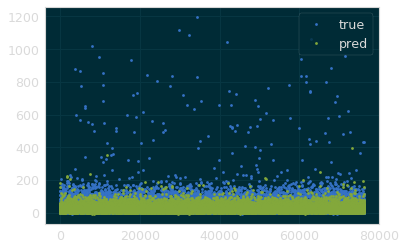

In [127]:
test_res.sort_values(by='true').plot(style='.')

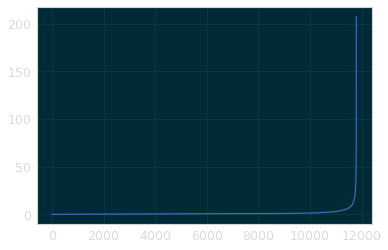

In [128]:
((test_res.pred - test_res.true) / test_res.true).abs().sort_values().reset_index(drop=True).plot()

In [129]:
relative_error = ((test_res.pred - test_res.true) / test_res.true).abs()

In [ ]:
(relative_error == np.inf).sum()

977

In [ ]:
relative_error[np.isfinite(relative_error)].mean()

1.2284908677951032

## Pseudo AB test

In [ ]:
def predict_profit_with_offer(view_model, profit_model, data, offer, drop_offer_id=False):
    """ Predicts how much will be the profit in 10 days for a given an offer. """
    samples = data.copy()
    if drop_offer_id:
        std_offer = offer.drop('id').rename(index={'reward': 'reward_t'})
    else:
        std_offer = offer.rename(index={'reward': 'reward_t', 'id': 'offer_id'})
    samples.loc[:, std_offer.index] = np.repeat(std_offer.values.reshape(1, -1), samples.shape[0], axis=0)
    
    if offer.offer_type == 'no_offer':
        vis_probas = np.ones(samples.shape[0])
    else:
        vis_probas = view_model.predict_proba(samples)[:, 1]

    profit_pred = profit_model.predict(samples)
    
    y_pred = vis_probas * profit_pred
    
    return pd.Series(y_pred, name=offer.id).T

In [ ]:
complete_portfolio.iloc[10:, :]

,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_email,channel_web
10,0,0,no_offer,no_offer,0,0,0,0,0


In [ ]:
predict_profit_with_offer(model, profit_est_model, X_test, complete_portfolio.iloc[1, :])

In [ ]:
def choose_offer(view_model, profit_model, X, portfolio, add_null_offer=True):
    """
    Given a model and a features dataframe it returns the
    model that maximizes the model predictions.
    """
    complete_portfolio = portfolio.copy()
    
    # Add the null offer
    if add_null_offer:
        null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=complete_portfolio.columns, 
                               name=complete_portfolio.shape[0])
        complete_portfolio = complete_portfolio.append(null_offer)
    
    res = complete_portfolio.apply(
        lambda x: predict_profit_with_offer(view_model, profit_model, X, x), axis=1).T
    res.columns = complete_portfolio.id
    
    return res.idxmax(axis=1), res

In [ ]:
selected_offers, predicted_full = choose_offer(model, profit_est_model, X_test, portfolio)
selected_offers.head()

In [ ]:
selected_offers.value_counts()

In [ ]:
(X_test.offer_id == selected_offers.values).mean()

In [ ]:
(X_test.offer_id == selected_offers.values).sum()

We could check the actual profit on those samples that, by chance, were sent the selected offer.

In [ ]:
coincidences = y_test[X_test.offer_id == selected_offers.values]
coincidences.sum()

Now we select a random sample, of the same size, from the test set, and compare with the above profit.

In [ ]:
np.random.seed(2018)
np.random.choice(y_test, coincidences.shape[0], replace=False).sum()

## 4) Let's deal with the overlapping.